In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ayaanbari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import json
import re

titles = []
categories = []

with open('News_Category_Dataset_v3.json', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        try:
            entry = json.loads(line)
            if len(entry) >= 3 and entry['category'] in ['POLITICS', 'ENTERTAINMENT', 'SPORTS', 'BUSINESS', 'HEALTHY LIVING']:
                title = entry['headline'].lower()
                title = title.strip()
                title = re.sub(r'\W+', ' ', title)  # Remove non-word characters
                titles.append(title)
                categories.append(entry['category'])
        except json.JSONDecodeError:
            print(f"Error decoding JSON in line: {line}")

print("Titles:\n", "\n".join(titles))
print("\nCategories:\n", "\n".join(categories))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [4]:
title_tr, title_te, category_tr, category_te = train_test_split(titles,categories)
title_tr, title_de, category_tr, category_de = train_test_split(title_tr,category_tr)
print("Training: ",len(title_tr))
print("Developement: ",len(title_de),)
print("Testing: ",len(title_te))

Training:  39783
Developement:  13262
Testing:  17682


<Figure size 640x480 with 0 Axes>

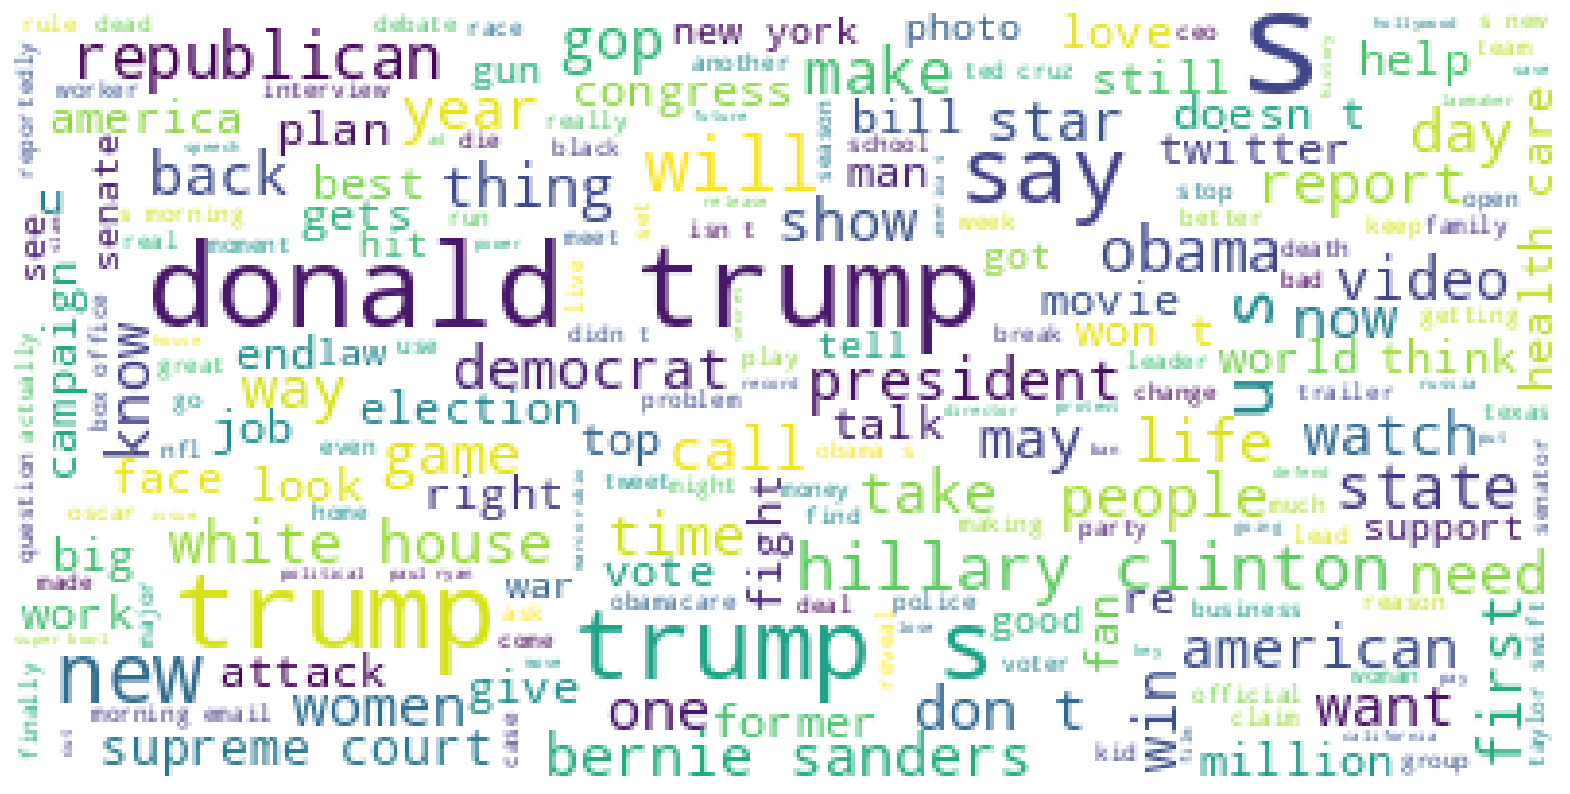

In [5]:
from wordcloud import WordCloud
text = " ".join(title_tr)
wordcloud = WordCloud().generate(text)
plt.figure()
plt.subplots(figsize=(20,12))
wordcloud = WordCloud(
    background_color="white",
    max_words=len(text),
    max_font_size=40,
    relative_scaling=.5).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [6]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
stop_words = nltk.corpus.stopwords.words("english")
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

vectorizer.fit(iter(title_tr))
Xtr = vectorizer.transform(iter(title_tr))
Xde = vectorizer.transform(iter(title_de))
Xte = vectorizer.transform(iter(title_te))

encoder = LabelEncoder()
encoder.fit(category_tr)
Ytr = encoder.transform(category_tr)
Yde = encoder.transform(category_de)
Yte = encoder.transform(category_te)

/home/ayaanbari/.local/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
reverse_vocabulary = {}
vocabulary = vectorizer.vocabulary_
for word in vocabulary:
    index = vocabulary[word]
    reverse_vocabulary[index] = word

vector = vectorizer.transform(iter(['Nasa scientists are good']))
indexes = vector.indices
for i in indexes:
    print (reverse_vocabulary[i])

good
nasa
scientists


In [8]:
print("Number of features before reduction : ", Xtr.shape[1])
selection = VarianceThreshold(threshold=0.001)
Xtr_whole = copy.deepcopy(Xtr)
Ytr_whole = copy.deepcopy(Ytr)
selection.fit(Xtr)
Xtr = selection.transform(Xtr)
Xde = selection.transform(Xde)
Xte = selection.transform(Xte)
print("Number of features after reduction : ", Xtr.shape[1])

Number of features before reduction :  25302
Number of features after reduction :  1505


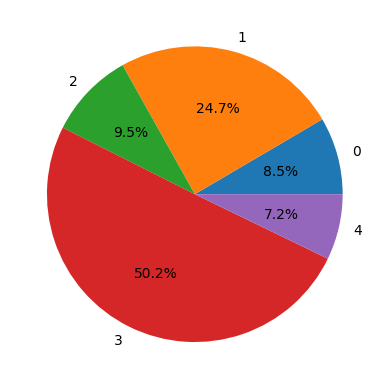

In [9]:
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

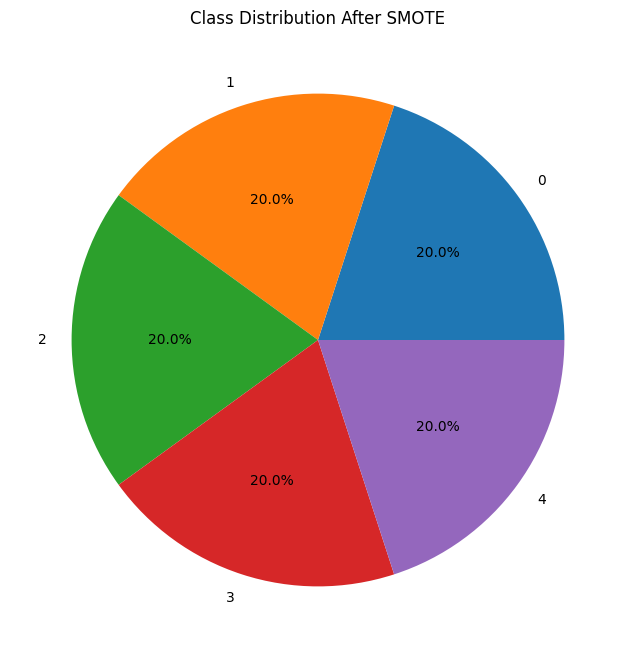

In [10]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# Assuming Xtr and Ytr are already defined and contain your data

sm = SMOTE(random_state=42)
Xtr_resampled, Ytr_resampled = sm.fit_resample(Xtr, Ytr)

labels = list(set(Ytr_resampled))
counts = [np.count_nonzero(Ytr_resampled == label) for label in labels]

plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Class Distribution After SMOTE')
plt.show()

In [11]:
dc = DummyClassifier(strategy="stratified")
dc.fit(Xtr, Ytr)
pred = dc.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                precision    recall  f1-score   support

      BUSINESS       0.08      0.08      0.08      1079
 ENTERTAINMENT       0.24      0.24      0.24      3226
HEALTHY LIVING       0.10      0.11      0.11      1262
      POLITICS       0.51      0.50      0.50      6765
        SPORTS       0.07      0.07      0.07       930

      accuracy                           0.33     13262
     macro avg       0.20      0.20      0.20     13262
  weighted avg       0.34      0.33      0.34     13262



In [12]:
dt = DecisionTreeClassifier()
dt.fit(Xtr, Ytr)
pred = dt.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                precision    recall  f1-score   support

      BUSINESS       0.36      0.44      0.40      1079
 ENTERTAINMENT       0.70      0.70      0.70      3226
HEALTHY LIVING       0.49      0.50      0.50      1262
      POLITICS       0.84      0.82      0.83      6765
        SPORTS       0.60      0.49      0.54       930

      accuracy                           0.71     13262
     macro avg       0.60      0.59      0.59     13262
  weighted avg       0.72      0.71      0.71     13262



In [13]:
rf = RandomForestClassifier(n_estimators=40)
rf.fit(Xtr, Ytr)
pred = rf.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                precision    recall  f1-score   support

      BUSINESS       0.45      0.41      0.43      1079
 ENTERTAINMENT       0.77      0.73      0.75      3226
HEALTHY LIVING       0.51      0.57      0.54      1262
      POLITICS       0.84      0.88      0.86      6765
        SPORTS       0.65      0.54      0.59       930

      accuracy                           0.75     13262
     macro avg       0.64      0.62      0.63     13262
  weighted avg       0.75      0.75      0.75     13262



In [14]:
nb = MultinomialNB()
nb.fit(Xtr, Ytr)
pred = nb.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                precision    recall  f1-score   support

      BUSINESS       0.59      0.39      0.47      1079
 ENTERTAINMENT       0.78      0.77      0.78      3226
HEALTHY LIVING       0.63      0.58      0.61      1262
      POLITICS       0.82      0.90      0.86      6765
        SPORTS       0.74      0.56      0.64       930

      accuracy                           0.77     13262
     macro avg       0.71      0.64      0.67     13262
  weighted avg       0.77      0.77      0.77     13262



In [15]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(Xtr, Ytr)
pred = svc.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                precision    recall  f1-score   support

      BUSINESS       0.69      0.33      0.45      1079
 ENTERTAINMENT       0.77      0.80      0.78      3226
HEALTHY LIVING       0.67      0.57      0.61      1262
      POLITICS       0.82      0.94      0.87      6765
        SPORTS       0.83      0.52      0.64       930

      accuracy                           0.79     13262
     macro avg       0.76      0.63      0.67     13262
  weighted avg       0.78      0.79      0.78     13262



In [16]:
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), random_state=1, max_iter=400)
mlp.fit(Xtr, Ytr)
pred = mlp.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                precision    recall  f1-score   support

      BUSINESS       0.49      0.41      0.45      1079
 ENTERTAINMENT       0.76      0.76      0.76      3226
HEALTHY LIVING       0.58      0.58      0.58      1262
      POLITICS       0.84      0.87      0.85      6765
        SPORTS       0.63      0.58      0.60       930

      accuracy                           0.76     13262
     macro avg       0.66      0.64      0.65     13262
  weighted avg       0.75      0.76      0.75     13262



                precision    recall  f1-score   support

      BUSINESS       0.58      0.39      0.46      1550
 ENTERTAINMENT       0.78      0.77      0.78      4323
HEALTHY LIVING       0.61      0.60      0.60      1672
      POLITICS       0.81      0.90      0.85      8849
        SPORTS       0.74      0.57      0.65      1288

      accuracy                           0.77     17682
     macro avg       0.71      0.65      0.67     17682
  weighted avg       0.76      0.77      0.76     17682



<Axes: >

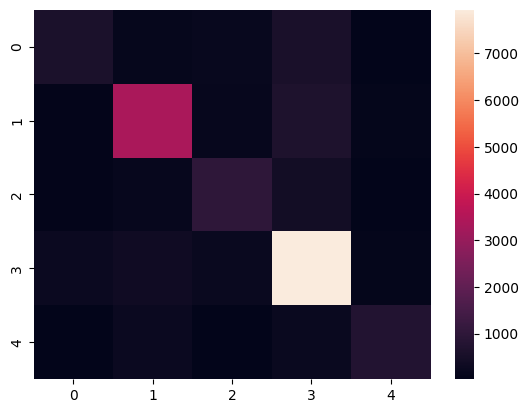

In [17]:
pred = nb.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(Yte, pred))

In [18]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# Assuming reverse_vocabulary is defined correctly

nb1 = MultinomialNB()
nb1.fit(Xtr_whole, Ytr_whole)

# Exponentiate the coefficients to interpret them as probabilities
coefs = np.exp(nb1.feature_log_prob_)

target_names = encoder.classes_

for i in range(len(target_names)):
    words = []
    for j in coefs[i].argsort():
        words.append(reverse_vocabulary[j])
    print(target_names[i], '-', words, "\n")

BUSINESS - ['kyron', 'object', 'obituary', 'obituaries', 'obit', 'obi', 'obey', 'obesity', 'obese', 'oberst', 'obamas', 'oats', 'oatmeal', 'oath', 'oar', 'oakley', 'oakland', 'oak', 'objectified', 'oaf', 'objecting', 'objections', 'observers', 'observer', 'observed', 'observe', 'observations', 'obscurity', 'obscure', 'obscene', 'oblivious', 'oblivion', 'obliterates', 'obliterated', 'obliterate', 'obliged', 'obligation', 'objectively', 'objective', 'objectionable', 'obsesses', 'oa', 'nyquist', 'nursing', 'nurses', 'nuri', 'nuptials', 'nuno', 'nunn', 'nunes', 'nunberg', 'nun', 'numerous', 'numb', 'numan', 'nullifying', 'nullify', 'nullifies', 'nukes', 'nuke', 'nurture', 'nyu', 'nurturing', 'nutrient', 'nypd', 'nyong', 'nymphomaniac', 'nyman', 'nylon', 'nyfw', 'nye', 'nxt', 'nutty', 'nuttiest', 'nutso', 'nutshell', 'nutritious', 'nutritionists', 'nutritionist', 'nutrition', 'nutrients', 'nut', 'nuggets', 'obsessives', 'obstacle', 'ohanian', 'ogg', 'ogden', 'offstage', 'offspring', 'offsho

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# Assuming reverse_vocabulary is defined correctly

# Initialize CountVectorizer
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

# Fit and transform training data
Xtr_transformed = vectorizer.fit_transform(title_tr)
Xte_transformed = vectorizer.transform(title_te)

# Train Multinomial Naive Bayes classifier
nb1 = MultinomialNB()
nb1.fit(Xtr_transformed, Ytr)

# Calculate accuracy on test data
pred = nb1.predict(Xte_transformed)
accuracy = np.mean(pred == Yte)
print('Accuracy:', accuracy)

/home/ayaanbari/.local/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.835934848998982


In [22]:
# Assuming reverse_vocabulary, tokenizer, stop_words, vectorizer, and nb1 are defined as in your previous code

# Example input data (replace this with your actual input data)
new_titles = [
    "Bitcoin is going off",
    "Donald Trump is going to hell",
    "dj",
    "football",
    "fruits"
]

# Transform the new titles using the CountVectorizer
X_new_transformed = vectorizer.transform(new_titles)

# Make predictions using the trained Multinomial Naive Bayes classifier
predictions = nb1.predict(X_new_transformed)

# Print the predicted categories for each new title
for title, prediction in zip(new_titles, predictions):
    print(f'Title: {title} | Predicted Category: {encoder.classes_[prediction]}')

Title: Bitcoin is going off | Predicted Category: BUSINESS
Title: Donald Trump is going to hell | Predicted Category: POLITICS
Title: dj | Predicted Category: ENTERTAINMENT
Title: football | Predicted Category: SPORTS
Title: fruits | Predicted Category: HEALTHY LIVING


In [23]:
import os
import sys
import pickle

projectabspathname = os.path.abspath('news_pickle.pickle')
print(projectabspathname)
projectname = 'news.ipynb'
projectpickle = open(str(projectabspathname),'wb')
pickle.dump(projectname, projectpickle)
projectpickle.close()

/home/ayaanbari/Downloads/NLTK MAIN/news_pickle.pickle


In [24]:
#from sklearn.datasets import load_iris
#from sklearn.ensemble import RandomForestClassifier
#import joblib

# Load the Iris dataset
#iris = load_iris()
#X, y = iris.data, iris.target

# Initialize and train a classifier
#classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#classifier.fit(X, y)

# Save the trained classifier to a pickle file
#filename = 'news_pickle.pickle'
#joblib.dump(classifier, filename)
